# 序列模型

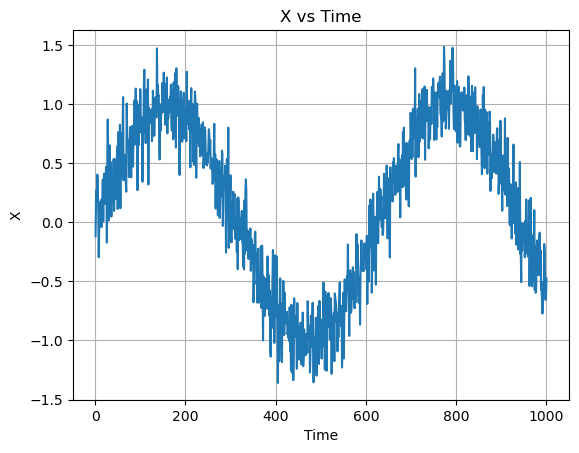

In [1]:
"""构造一个时间序列"""
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
T = 1000
time = torch.arange(1, T+1, dtype = torch.float32)
x = torch.sin(time * 0.01) + torch.randn((T)) * 0.2
plt.plot(time, x)  # 绘制折线图
plt.xlabel('Time')  # 添加x轴标签
plt.ylabel('X')  # 添加y轴标签
plt.title('X vs Time')  # 添加标题
plt.grid()  # 显示网格
plt.show()  # 显示图形

In [3]:
"""马尔可夫假设，看t-1到t-4个的x值"""
import self_d2l
tau = 4
features = torch.zeros(T - tau, tau)
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 按0，1，2，3开头，取四个tau长度的数组，预测后面的数
labels = x[tau:].reshape(-1,1) # tau到最后是正确结果
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = self_d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [5]:
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    return net


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for i in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f"epoch,{i+1} loss: {d2l.evaluate_loss(net, train_iter, loss):.6f}")
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch,1 loss: 0.067769
epoch,2 loss: 0.060336
epoch,3 loss: 0.056680
epoch,4 loss: 0.056322
epoch,5 loss: 0.058728


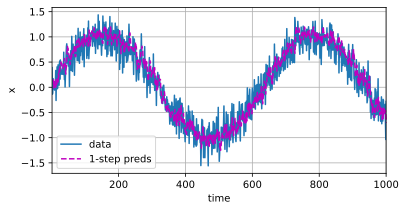

In [7]:
"""预测"""
onestep_preds = net(features)
d2l.plot([time, time[tau:]],[x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

没有预测噪音，结果有受噪声影响

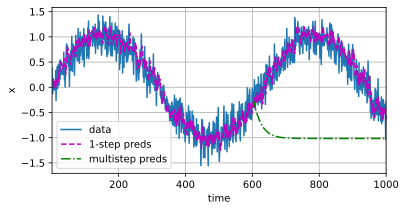

In [8]:
"""多步预测"""
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

用预测的数据来预测下一个数据，误差累积。

# 文本预处理

In [1]:
import collections
import re
from d2l import torch as d2l

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines] # 正则表达式，把非英语字母变成空格， stripe方法去除开头结尾空格，lower转小写

lines = read_time_machine()

print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [5]:
def tokenize(lines, token='word'):  
    """将文本行拆分为单词或字符标记。"""
    if token == 'word': # 是英文
        return [line.split() for line in lines] # split按空格拆分
    elif token == 'char': # 是中文
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [6]:
class Vocab:
    def __init__(self, tokens = None, min_freq = 0, reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  
    """统计标记的频率。"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [8]:
for i in(0, 10):
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [11]:
def load_corpus_time_machine(max_tokens=-1):
    #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
print(len(corpus), len(vocab))

170580 28


# 语言模型
## 自然语言统计

In [12]:
import torch
import random
from d2l import torch as d2l
tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
print(vocab.token_freqs[:10])

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


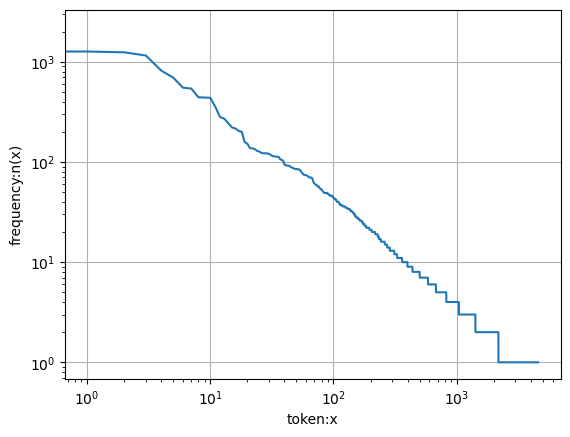

In [9]:
import matplotlib.pyplot as plt
"""一元语法"""
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(range(len(freqs)), freqs)
plt.xlabel("token:x")
plt.ylabel("frequency:n(x)")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

一元语法可以看出，占比大的词都是stop words暂停词，没有实际意义。词频的衰减模型大概是 $logn_i=-\alpha log i + c$（齐普夫定律）.
 这告诉我们想要通过计数统计和平滑来建模单词是不可行的，因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。

In [10]:
"""二元语法"""
bigram_tokens = [pair for pair in zip(corpus[: - 1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [8]:
"""三元语法"""
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('here', 'and', 'there'), 15),
 (('it', 'was', 'a'), 15),
 (('i', 'did', 'not'), 14),
 (('seemed', 'to', 'me'), 14),
 (('i', 'began', 'to'), 13),
 (('i', 'saw', 'the'), 13)]

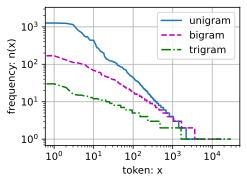

In [11]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

1. 看得出二元、三元词也满足齐普夫定律
2. 词表中n元组的数量并没有那么大，这说明语言中存在相当多的结构， 这些结构给了我们应用模型的希望
3. 很多n元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。 作为代替，我们将使用基于深度学习的模型

## 读取长序列数据

In [27]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    corpus = corpus[random.randint(0, num_steps-1):]
    num_substeps = (len(corpus)-1) // num_steps # -1是为了考虑标签，标签取的是特征的下一项
    initial_indices = list(range(0, num_substeps * num_steps, num_steps))
    random.shuffle(initial_indices)
    def data(pos):
        return corpus[pos : pos + num_steps]
    num_batches = num_substeps // batch_size # batch数
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch] # 特征
        Y = [data(j+1) for j in initial_indices_per_batch] # 标签，取特征的下一个数
        yield torch.tensor(X), torch.tensor(Y) # yield 的函数被称为生成器函数。当你调用这样的函数时，它不会立即执行，而是返回一个生成器对象,当使用时，可以获得所有的值
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, 2, 5):
    print(f'X:{X}, \nY:{Y} \n')

X:tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]]), 
Y:tensor([[28, 29, 30, 31, 32],
        [ 8,  9, 10, 11, 12]]) 

X:tensor([[17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6]]), 
Y:tensor([[18, 19, 20, 21, 22],
        [ 3,  4,  5,  6,  7]]) 

X:tensor([[12, 13, 14, 15, 16],
        [22, 23, 24, 25, 26]]), 
Y:tensor([[13, 14, 15, 16, 17],
        [23, 24, 25, 26, 27]]) 



## 顺序分区

In [26]:
"""将上面的两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器。"""
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
def load_data_time_machine(batch_size, num_steps,
    #@save
    use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

def load_data_time_machine(batch_size, num_steps,
    #@save
    use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 循环神经网络
![rnn](https://zh-v2.d2l.ai/_images/rnn.svg)

![rnn](https://zh-v2.d2l.ai/_images/rnn-train.svg)
## 从零实现

In [4]:
%matplotlib inline
import math
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
batch_size , num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps) # vocab储存整数和字符的对应转换

In [5]:
"""one-hot encoding"""
nn.functional.one_hot(torch.tensor([0, 2]), len(vocab)) # 生成的编码会变成2 * 28的形状
# 一开始0和2代表词的位置，一共有两个词。变成热度编码后还是两个词，每个词由28个数字表示，0和2位分别为1

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [6]:
"""小批量数据"""
X = torch.arange(10).reshape(2,5) # 2批量 5时间步
F.one_hot(X.T, 28).shape # 5时间步 2批量 

torch.Size([5, 2, 28])

In [7]:
"""初始循环神经网络参数"""
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    W_xh = torch.randn(size = (num_inputs,num_hiddens), device = device) * 0.01
    W_hh = torch.randn(size = (num_hiddens,num_hiddens), device = device) * 0.01
    b_h = torch.zeros(num_hiddens, device = device)
    W_hq = torch.randn(size = (num_hiddens, num_outputs), device = device)
    b_q = torch.zeros(num_outputs, device = device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    params = [param.requires_grad_(True) for param in params]
    return params

In [8]:
def init_rnn_state(batch_size, num_hiddens, device):
    return(torch.zeros(batch_size, num_hiddens, device = device),)

In [16]:
"""在一个时间步内计算隐藏状态和输出"""
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq + b_q)
        outputs.append(Y)
    return torch.cat(outputs, dim = 0), (H, )

In [44]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
        get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)
    

In [45]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [46]:
"""预测函数"""
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在predict后面生成新的字符"""
    state = net.begin_state(batch_size = 1, device = device)
    output = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([output[-1]], device = device).reshape(1, 1) # 这是一个函数，用于获得output的最后一位
    for y in prefix[1:]: # 预热期 相当于先用已知的语料传一遍state参数，rnn在预测的时候需要不断向后传参
        _, state = net(get_input(), state)
        output.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        output.append(vocab[y])
    return ''.join([vocab.idx_to_token[i] for i in output])
predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>'

In [47]:
"""梯度裁剪"""
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters if p.require_grad]
    else : params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [50]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练一个周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
        # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
            # 不随机的话相邻批量的第i个数据是连着的两个词，见上方class RNNModelScratch的__call__的X.T
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter = False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter) # 困惑度和速度
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 12.5, 13806.4 词元/秒 cpu
time traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


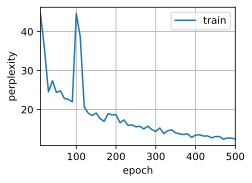

In [42]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())
## 简洁实现

困惑度 12.7, 22405.5 词元/秒 cpu
time traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


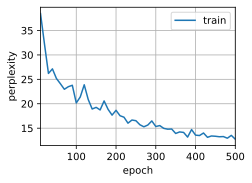

In [49]:
"""看看随机抽样方法"""
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),use_random_iter=True)

## API实现

In [56]:
num_hoddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
"""pytorch的rnn没有输出层"""
state = torch.zeros(1, batch_size, num_hiddens)
X = torch.rand((num_steps, batch_size, len(vocab)))
Y, state = rnn_layer(X, state)
state.shape, Y.shape, state.shape

(torch.Size([1, 32, 512]), torch.Size([35, 32, 512]), torch.Size([1, 32, 512]))

In [57]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [58]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerxfnfnwfntn'

perplexity 1.0, 26277.2 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


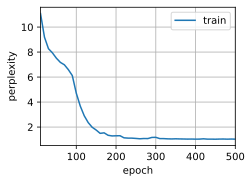

In [59]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 门控循环单元（GRU）
$$R_t = \sigma(X_tW_{xr}+H_{t-1}W_{hr}+b_r)$$
$$Z_t = \sigma(X_tW_{xz}+H_{hz}+b_z)$$
$$\tilde{H_{t}} = tanh(X_tW_{xh}+(R_t\odot H_{t-1})W_{hh}+b_h)$$
$$H_{t} = Z_t\odot H_{t-1}+(1-Z_t)\odot \tilde{H_t}$$
符号⊙是Hadamard积（按元素乘积）运算符

$R_t$是Reset gate，
$Z_t$是Update Gate，
$H_t$是Candidate Hidden State.

重置门$R_t$能控制候选隐藏态，更新门$Z_t$能控制隐藏态的更新

In [11]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )
"""参数初始化"""
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def three():
        return (normal((num_inputs, num_hiddens)),
    normal((num_hiddens, num_hiddens)),
    torch.zeros(num_hiddens, device=device))
    W_xz, W_hz, b_z = three()
    # 更新门参数
    W_xr, W_hr, b_r = three()
    # 重置门参数
    W_xh, W_hh, b_h = three()
    # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [10]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # @和torch.mm(必须是矩阵向量不行)和torch.matmul和torch.dot等价，矩阵乘法
    # *和torch.mul等价，按元素相乘
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z) 
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 2627.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


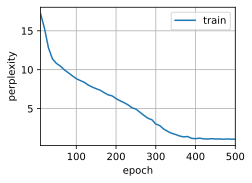

In [12]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 24433.9 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


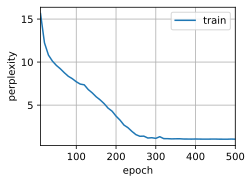

In [13]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))# pytorch自带GRU没有输出层，加一个
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# LSTM（长短期记忆网络）
* 忘记门:将值朝0减少
* 输入门:决定是否忽略输入数据
* 输出门:决定是否使用隐藏状态

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 从零手搓

In [2]:
"""记忆元参数初始化"""
def get_lstm_params(vocab_num, num_hidden, devices):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def three():
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), 
                torch.zeros(num_hiddens, device=device))
    W_xi, W_hi, b_i = three() # input gate parameters
    W_xf, W_hf, b_f = three() # forget gate parameters
    W_xo, W_ho, b_o = three() # output gate parameters
    W_xc, W_hc, b_c = three() # cadidate gate parameters
    # output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
    b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
"""记忆元状态初始化"""
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
        torch.zeros((batch_size, num_hiddens), device=device))
"""lstm模型初始化"""
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H,C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim = 0),(H, C)


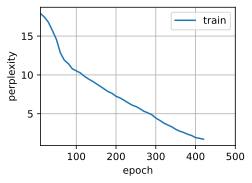

In [3]:
"""train"""
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 高级API实现

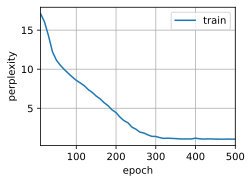

In [5]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens) # 隐藏状态参数根据输入的形状来，以便获得结果向量
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 深层循环神经网络

In [6]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

travelleryou can show black is white by argument said filby


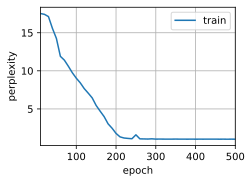

In [7]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
device = d2l.try_gpu()
model = model.to(device)
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

# 双向循环神经网络
双向循环神经网络无法预测，只能抽取信息或完形填空

time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


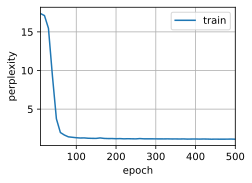

In [8]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True) # bidirectional表示双向
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)
# 从结果可以看出双向神经网络不能用于预测

# 机器翻译与数据集

In [2]:
import os
import torch
from d2l import torch as d2l
"""英语翻译成法语"""
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip','94646ad1522d915e7b0f9296181140edcf86a4f5')
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i>0 and no_space(char, text[i-1]) else char for i, char  in enumerate(text)]
    return ''.join(out) # .join(out) 是一个字符串方法，它将列表 out 中的所有元素连接成一个单一的字符串。
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [7]:
"""词元化"""
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')): # 先把每行分开
        if num_examples and i > num_examples:
            break
        parts = line.split('\t') # 再把英语和法语两个词分开
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

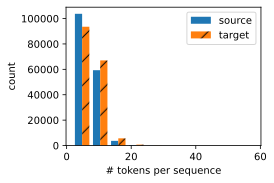

In [8]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence','count', source, target);

In [10]:
"""词表"""
src_vocab = d2l.Vocab(source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
# 在小批量时用于将序列填充到相同长度的填充词元<pad>
# 以及序列的开始词元<bos>
# 序列结束词元<eos>
len(src_vocab)

10012

In [11]:
"""加载数据集"""
def truncate_pad(line, num_steps, padding_token): # 训练的句子需要定长，如果不够就加 padding，多了就截断
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [12]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1) # 统计排除填充之后字元的长度
    return array, valid_len

In [13]:
def load_data_nmt(batch_size, num_steps, num_examples = 600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
    reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [17]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size = 2, num_steps = 8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print("X:", X.type(torch.int32))
    print("X的有效长度", X_valid_len)
    print("Y:", Y.type(torch.int32))
    print("Y的有效长度", Y_valid_len)
    break

X: tensor([[170,   8,   4,   3,   1,   1,   1,   1],
        [ 13,   0,   5,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度 tensor([4, 4])
Y: tensor([[ 0,  5,  3,  1,  1,  1,  1,  1],
        [27,  0,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度 tensor([3, 4])


# 编码解码

API实现

In [19]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    def forward(self, X, *args):
        raise NotImplementedError
        # 抛出异常，如果在子类中没有实现这些抽象方法，那么当调用这些方法时，就会抛出 NotImplementedError

class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# seq2seq 序列到序列学习

In [2]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
class Seq2SeqEncoder(d2l.Encoder):
    """编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, ** kwargs):
         super(Seq2SeqEncoder, self).__init__(**kwargs)
         # 嵌入层
         self.embedding = nn.Embedding(vocab_size, embed_size)
         self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,dropout=dropout)
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state
encoder = Seq2SeqEncoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
encoder.eval()
X = torch.zeros((4,7), dtype = torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
        dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [16]:
def sequence_mask(X, valid_len, value = 0):
    """屏蔽序列中不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange(maxlen, dtype = torch.float32, device = X.device)[None, :] < valid_len[:, None]
    # 索引中的None关键字增加了张量的维度
    # x = [1, 2, 3] x[None, :] = [[1,2,3]]
    # x = [1, 2, 3] x[:,None] = [[1], [2], [3]]
    X[~ mask] = value
    return X
X = torch.tensor([[1, 2, 3],[4, 5, 6]])
sequence_mask(X, torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [10]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [24]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)# 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} 'f'tokens/sec on {str(device)}')

loss 0.023, 4655.2 tokens/sec on cpu


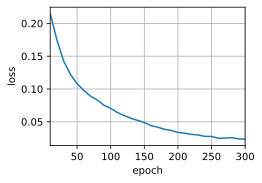

In [25]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [26]:
"""预测"""
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [27]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [28]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> est ?, bleu 0.447
i'm home . => je refuse ., bleu 0.000
